**Stat 542 - Statistical Learning**

**Fall 2022**

**Coding Assignment #3**

**Author: Paolo Furlanetto Ferrari**

**Date: October 10, 2022**

## Part I

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import loess.loess_1d as loess
import patsy
from sklearn.cluster import KMeans

**1. Computing one variable Loess**



Here, I'm using the Loess template provided in Python. Let me first test it:

In [13]:
def one_var_loess(x, y, alpha):
    n = x.size
    q = int(alpha * n)

    # compute the absolute distance and sort the result
    d = np.abs(np.subtract.outer(x, x)).squeeze()
    ds = np.sort(d, axis=0)
    dq = ds[q - 1, :]

    # compute the tricube weights
    d_mask = d >= dq[None, :]
    d_mask[:, 0]
    tri_weight = np.ma.masked_array(d, d_mask)
    tri_weight = (1 - (tri_weight / dq[None, :]) ** 3) ** 3
    tri_weight = tri_weight.filled(0)
    tri_weight[:, 0]

    # compute the fitted value with quadratic weighted least squares
    x_mat = np.hstack((np.ones((n, 1)), x, x ** 2))
    loess_beta = np.zeros((3, n))
    for i in range(n):
        x_mat_weighted = x_mat.T * tri_weight[:, i]
        loess_beta[:, i] = np.linalg.solve(x_mat_weighted @ x_mat, x_mat_weighted @ y).squeeze()

    # we only need the diagonal elements of (x_mat @ loess_beta)
    loess_fit = (x_mat * loess_beta.T).sum(-1)
    
    return(loess_fit)

Plotting the fitted model to see if it is accurate:

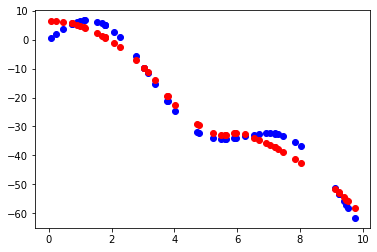

In [3]:
# Define x values
x = 10*np.random.rand(50,1)

# Compute an arbitrary function of x
y = -x**2+0.05*x**3-x + 10*np.sin(x)

# Plot the function
p = plt.plot(x,y, 'bo')

# Perform Loess fit
ylo = one_var_loess(x, y, 0.8)

plt.plot(x, ylo, 'ro')




The Loess function seems to work fine since the fitted curve is very close to the original!


**2. Writing the code for LOO-CV and GCV**

In [4]:
def lo_lev(x1, sp):
  # x1: feature vector of length n
  # sp: a value for "span"
    n = x1.size
    lev = np.zeros(n)
    for i in range(n):
        y = np.repeat(0, n)
        y[i] = 1
        yout = one_var_loess(x1, y, sp)
        lev[i] = yout[i]
    return(lev)

def onestep_CV(x1, y1, sp):
  
    ##############################################
    #  YOUR CODE: 
    #  1) Fit a loess model y1 ~ x1 with span = sp, and extract 
    #     the corresponding residual vector
    #  2) Call lo_lev to obtain the diagonal entries of S
    #  3) Compute LOO-CV and GCV using formula from lecture notes
    #    [lec_W5_NonlinearRegression.pdf] page 33. 
    ##############################################
    n = x1.size
    yout = one_var_loess(x1, y1, sp).reshape((30,1))
    res = y1 - yout
    S = lo_lev(x1, sp)
    trace = S.sum()/n
    cv = 0
    gcv = 0
    for i in range(n):
        cv = cv + (res[i]/(1-S[i]))**2
        gcv = gcv + (res[i]/(1-trace))**2
    

    return(np.array([cv/n, gcv/n]))
    


def myCV(x1, y1, span):
    # x1: feature vector of length n
    # y1: response vector of length n
    # span: a sequence of values for "span"
  
    m = span.size
    cvo = np.zeros(m)
    gcvo = np.zeros(m)

    for i in range(m):
        tmp = onestep_CV(x1, y1, span[i])
        cvo[i] = tmp[0]
        gcvo[i] = tmp[1]

    return cvo, gcvo

**3. Testing the LOO-CV and G-CV functions**

Checking the data, fitting for span = 0.25 and plotting it:

In [5]:
mydata = pd.read_csv("Coding3_Data.csv")
xt = np.array(mydata.x)
yt = np.array(mydata.y)
xt = xt.reshape((xt.size, 1))
yt = yt.reshape((yt.size, 1))
#plt.plot(xt, yt, 'bo')
yfit = one_var_loess(xt, yt, 0.25)
#plt.plot(xt, yfit, 'ro')

Defining range of spans and calling the CV routines:

In [6]:
spant = np.linspace(0.2, 0.9, 15)
LOOCV, GCV = myCV(xt, yt, spant)


**4. Printing the results:**

In [7]:
dict_CV = {'LOO-CV': LOOCV, 'G-CV': GCV, 'span': spant}
CV_df = pd.DataFrame(data = dict_CV)
print(CV_df)

       LOO-CV      G-CV  span
0   12.416166  2.109088  0.20
1    2.241351  1.489063  0.25
2    1.502957  1.190075  0.30
3    1.302611  1.155223  0.35
4    1.223215  1.081272  0.40
5    1.173550  1.046493  0.45
6    1.121463  1.016964  0.50
7    1.166369  1.105829  0.55
8    1.172145  1.112322  0.60
9    1.228412  1.158067  0.65
10   1.273253  1.209565  0.70
11   1.319765  1.266375  0.75
12   1.514219  1.440057  0.80
13   1.792494  1.703384  0.85
14   1.878643  1.782755  0.90


The optimal span is 0.5 in both validations!

**5. Plotting the optimal fitted curve:**

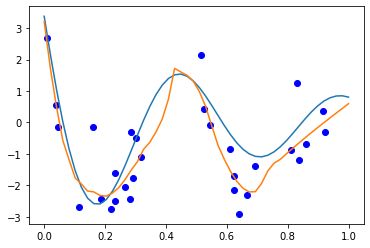

In [8]:
# Original curve
x_orig = np.linspace(0, 1, 50).reshape((50,1))
y_orig = np.sin(12*(x_orig+0.2))/(x_orig+0.2)

# Plot the original data
p = plt.plot(xt, yt, 'bo')

# Plot the original curve
p = plt.plot(x_orig, y_orig)

# Predict Loess curve with optimal span = 0.5 using Python loess package (https://pypi.org/project/loess)
xout, yout, wout = loess.loess_1d(xt.flatten(), yt.flatten(), xnew = x_orig, degree = 2, frac = 0.5)
plt.plot(xout, yout)




The fitted curve (in orange) approximates the original curve (blue). However, I realized that the fitted curve looks slightly different than the one in the Coding Assignment. It is likely because of numerical approximation of the loess package in Python.

## Part II

In [9]:
np.random.seed(3213)

**1. Visualizing the data:**

In [10]:
mydata = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
#print(mydata.head())

**2. Removing the mean:**


In [11]:
mydata_mat = np.array(mydata)[:,1:53]
X = mydata_mat - np.mean(mydata_mat, axis = 1).reshape(811,1)
X.shape


(811, 52)

**3. NCS fitting:**


i. First, obtain design matrix

In [12]:
xindex = np.linspace(1, 52, 52)
xdata = {"x": xindex}

F = patsy.dmatrix("cr(x, df = 9, constraints=None)", xdata)[:,1:10]


ii. Then, obtain matrix B

In [13]:
BT = np.matmul(np.linalg.inv(np.matmul(F.T, F)), np.matmul(F.T, X.T))
B = BT.T
print(B.shape)

(811, 9)


**4. K-means clustering with B matrix:**

i. Use scikitlearn library for k-means with k = 6:

In [14]:
kmeansB = KMeans(n_clusters=6).fit(B)
centersB = kmeansB.cluster_centers_
labelsB = kmeansB.labels_



**5. K-means clustering with X matrix:**

In [15]:
kmeansX = KMeans(n_clusters=6).fit(X)
centersX = kmeansX.cluster_centers_
labelsX = kmeansX.labels_



**6. Plotting the clustered data:**

Text(0.5, 0.98, 'Clustering with X')

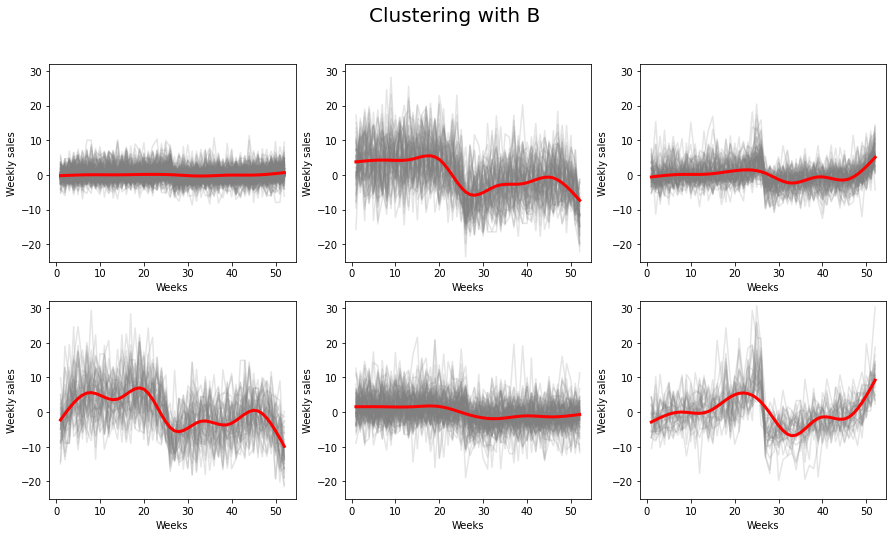

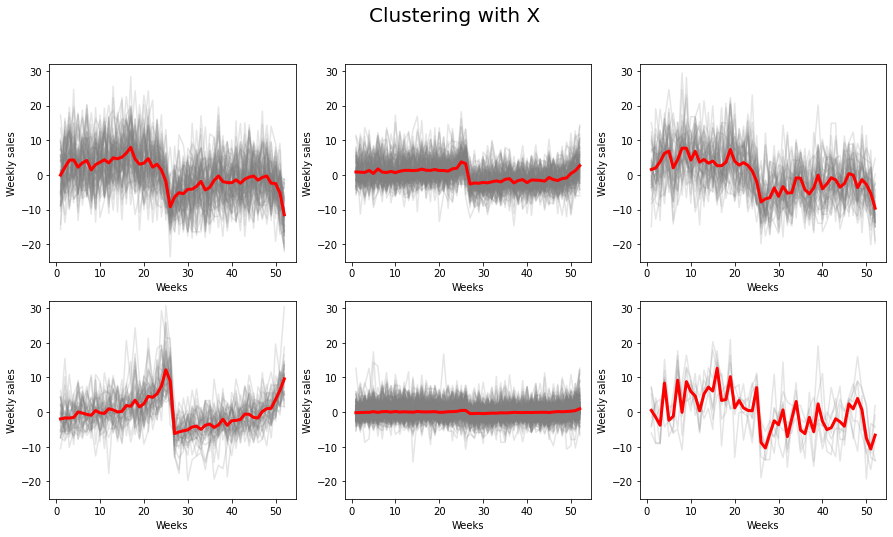

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3)
label = 0

for row in ax:
    for col in row:
        yfit1 = np.matmul(F, centersB[label])
        for i in range(811):
            if labelsB[i] == label:
                col.plot(xindex, X[i,:], color = 'gray', alpha=0.2)
        col.plot(xindex, yfit1, linewidth = 3, color = 'red')
        col.set(ylabel = 'Weekly sales', xlabel = 'Weeks', ylim = [-25,32])
        label += 1

fig = plt.gcf()
fig.suptitle('Clustering with B', fontsize = 20)
fig.set_size_inches(15, 8)



fig, ax = plt.subplots(nrows=2, ncols=3)
label=0
for row in ax:
    for col in row:
        yfit1 = centersX[label]
        for i in range(811):
            if labelsX[i] == label:
                col.plot(xindex, X[i,:], color = 'gray', alpha=0.2)
        col.plot(xindex, yfit1, linewidth = 3, color = 'red')
        col.set(ylabel = 'Weekly sales', xlabel = 'Weeks', ylim = [-25,32])
        label += 1

fig = plt.gcf()
fig.set_size_inches(15, 8)
fig.suptitle('Clustering with X', fontsize = 20)



## Part III


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


**1. Reading and centering the data:**

In [6]:
mydata = pd.read_csv("Coding3_dataH.csv")
Ydata = np.array(mydata)[:,0]
print(Ydata.shape)
Xdata = np.array(mydata)[:,1:241]

Xdata = Xdata - np.mean(Xdata, axis = 1).reshape(505,1)
print(Xdata.shape)

(505,)
(505, 240)


**2. PCA using scikitlearn:**

In [7]:
def myPCA(Xtrain, Xtest):
    pca = PCA()
    pca.fit(Xtrain)
    Xtrain_trans = pca.transform(Xtrain)
    Xtest_trans = pca.transform(Xtest)
    
    # Drop singular values < e-10**
    singular_values = pca.singular_values_[pca.singular_values_>10**(-10)]
    #print(pca.singular_values_>10**(-10))
    Xtrain_trans = Xtrain_trans[:,pca.singular_values_>10**(-10)]
    Xtest_trans = Xtest_trans[:,pca.singular_values_>10**(-10)]

    return Xtrain_trans, Xtest_trans


**3. Obtain coefficients and errors:**

In [8]:
def errorPCA(Xtrain, Ytrain, Xtest, Ytest):
    Xtrain_trans, Xtest_trans = myPCA(Xtrain, Xtest)
    #print(Xtrain_trans.shape, Xtest_trans.shape)
    betas = np.matmul(Xtrain_trans.T, Ytrain)
    #print(betas.shape)
    return (1/Ytest.size)*np.sum((Ytest - np.matmul(Xtest_trans, betas))**2)


**4. Simulation study:**

Text(0, 0.5, 'Median of MSE')

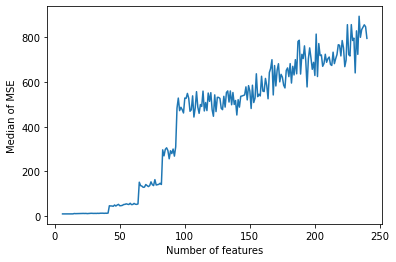

In [11]:
indices = np.linspace(0, 504, 504)
split_index = int(np.floor(0.25*504))
D = range(6,241)
e = np.zeros((30, 235))

for t in range(30):
    for d in D:
        np.random.shuffle(indices)
        u = indices[0:split_index]
        Xtrain = np.array([Xdata[int(sh),:] for sh in indices[0:split_index]])[:,0:d]
        #print(Xtrain)
        Ytrain = np.array([Ydata[int(sh)] for sh in indices[0:split_index]])    
        #print(Ytrain.shape)
        Xtest = np.array([Xdata[int(sh),:] for sh in indices[split_index:504]])[:,0:d]
        #print(Xtest.shape)
        Ytest = np.array([Ydata[int(sh)] for sh in indices[split_index:504]])
        #print(Ytest.shape)
        e[t, d-6] = (errorPCA(Xtrain, Ytrain, Xtest, Ytest))

medians = np.median(e, axis = 0)
plt.plot(D, medians)
plt.xlabel('Number of features')
plt.ylabel('Median of MSE')


In [85]:
e[:,2]

array([ 9.50678183,  9.60663529,  9.64856037,  9.67233445,  9.40607909,
        9.56011846,  9.50714933,  9.36946722,  9.28318211,  9.18444894,
        9.70720581,  9.52491483, 10.00651918,  9.26994264,  9.52917517,
        9.33153273,  9.52603824,  9.93373195,  9.33596321,  9.25097724,
        9.52869774,  9.76864868,  9.39832912,  9.76922185,  9.56017731,
        9.34300442,  9.39543179,  9.43603801,  9.47966591,  9.39070174])